# Classical Combination of Quantum States

The Classical Combination of Quantum States (CQS) method is implemented below. The main implementation of CQS and the Ansatz Tree is imported from the quantum_classical_hybrid.py file. The problem is specified in the notebook.

This method appears in 
Hsin-Yuan Huang et al.  "Near-term quantum algorithms for linear systems of equations" (2019) [arXiv:1909.07344]

(Note that this CQS method is implemented using the Statevector simulator and not the QASM Simulator.Changing the the QASM simulator requires altering the Hadamard Test circuits in quantum_classical_hybrid.py wherever they occur.)

[Note the Python library 'cvxopt' is required to run this notebook]

In [1]:
#imports
import random
from math import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from scipy.optimize import minimize
import copy
import numpy as np
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

import quantum_classical_hybrid as cqs

## Specify the Problem

Specifying the problem involves giving the number of qubits, and giving the relevant linear system $A\vec{x} = \vec{b}$ to be solved.

$A$ is a $2^n \times 2^n$ matrix given as a linear combination of $k$ unitary matrices $A = \Sigma_i c_iA_i$. 

n_qubits = $n$ if  $A$ is a $2^n \times 2^n$ matrix

The values for $c_i$ are given in the coefficient list, $[c_0, ..., c_k]$.

The unitaries $A_i$, of size $2^n \times 2^n$, are given as controlled versions of their respective quantum gates, with the idx value in the create_state_A_i function corresponding to the coefficent in the coefficent list at that same idx value, $c_{idx}$.

The control bit is assumed to be qubit 0, while the $A_i$ is to take up the $n$ qubits from $[1, ..., n]$. See diagram below for clarity.

$\vec{b}$ is given as a quantum state $|b>$ which is implemented here as the controlled version of the unitary gate $U$ such that $|b> = U|0>$.

(Both $A_i$ and $U$ are implemented as controlled gates as per the cost function)

This example problem gives $A = I + 0.2 \cdot  X_1 Z_2 + 0.2 \cdot  X_1$ (Where $X_1$ denotes an $X$ gate applied to the 1st qubit, similarly for the rest. $I$ denotes the Identity matrix (size 8 x 8 in this example) )

In [2]:
#specific to problem
n_qubits = 3 
coefficients = [1, 0.2, 0.2]

def create_controlled_state_b(quantum_circuit, qubits):
    for i in qubits:
        quantum_circuit.ch(0,i)
        
def create_controlled_state_b_dg(quantum_circuit, qubits):
    create_controlled_state_b(quantum_circuit, qubits)
    
def create_state_A_i(quantum_circuit, idx):#assumed 0 is hadamard test ancilla
    if(idx == 0):
        None
    if(idx == 1):
        quantum_circuit.cx(0,1)
        quantum_circuit.cz(0,2)
    if(idx == 2):
        quantum_circuit.cx(0,1)          
        
def create_state_A_i_dg(quantum_circuit, idx):
    create_state_A_i(quantum_circuit, idx)

An Ansatz_Tree object must be initiated, given by

Ansatz_Tree(n_qubits, controlled_state_b, controlled_state_b_dg, controlled_A_l, controlled_A_l_dg, unitary_coefficients)

| | |
|-|-|
|n_qubits|  number of qubits in the problem.|
|controlled_state_b| function to create controlled version of $U$|
|controlled_state_b_dg| function to create controlled version of $U^\dagger$|
|controlled_A_l| function to create controlled version of unitary $A_i$|
|controlled_A_l_dg| function to create controlled version of unitary $A_i^\dagger$|
|unitary_coefficients| list of coefficients, $[c_0, ..., c_k]$|

Once an Ansatz Tree object is instantiated, it initially contains only the state |b> as the root node. 
Calling the solve method will find an approximate solution to the system of linear equations given the nodes in the tree.

There are currently 2 ways to expand the tree, bfs_add and heuristic_add. The solve method must be run before heuristic_add can be called.

The solution_overlap method returns the current value of the cost function for the approximate solution. 

The return_solution_dictionary returns as plottable dictionary of the solution in a way comparable to the VQLS method. 

2 nodes 1.376197766518997e-15
3 nodes 1.3748113070023508e-15
4 nodes 1.3612899561440935e-15
5 nodes 1.0318366699923372e-15
6 nodes 1.3549082248576888e-15
[ 0.17142835-6.34159781e-08j -0.14285714-7.33010682e-19j
  0.17142841-4.43835995e-08j  0.1714287 +3.59331925e-08j
  0.1714287 +3.59331925e-08j  0.1714287 +3.59331925e-08j]


/home/aidan/anaconda3/lib/python3.8/site-packages/qiskit/visualization/counts_visualization.py:239: ComplexWarning: Casting complex values to real discards the imaginary part
  values = np.array(values, dtype=float)


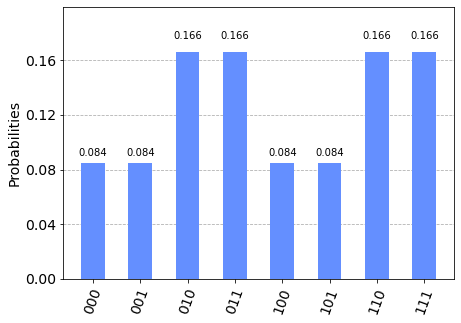

In [3]:
n_expansions = 6
ansatz_tree = cqs.Ansatz_Tree(n_qubits, create_controlled_state_b, create_controlled_state_b_dg, create_state_A_i, create_state_A_i_dg, coefficients)
ansatz_tree.solve()

for i in range(2, n_expansions+1):
    ansatz_tree.heuristic_add() #Alternatively -> ansatz_tree.bfs_add()
    ansatz_tree.solve()
    sol = ansatz_tree.solution_overlap()
    print("{0} nodes".format(i), sol)
print(ansatz_tree.solution)

result = ansatz_tree.return_solution_dictionary()
plot_histogram(result)